In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline 
from tqdm import tqdm
import numpy as np
import os
from random import shuffle
import cv2

train_dir = "./dogs-vs-cats/train/train"
test_dir = "./dogs-vs-cats/test1/test1"
lr = 1e-3
model_name = "dogsvscats--{}--{}.model".format(lr, "CNN-dogs-cats")
image_size = 50 

In [2]:
def label_img(img):
    word_label = img.split(".")[-3]
    if word_label == "cat":
        return [1,0]
    elif word_label == "dog":
        return [0,1]

# Function creating training data for the model 
def create_train_data():
    training_data=[]
    for img in tqdm(os.listdir(path=train_dir)):
        label = label_img(img)
        path_to_img = os.path.join(train_dir, img)
        img = cv2.imread(path_to_img, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (image_size, image_size))
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    np.save("train_data.npy", training_data)
    return training_data

In [3]:
# Function creating testing data after finishing building the model 
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(test_dir)):
        path = os.path.join(test_dir, img)
        img_num = img.split(".")[0]
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (image_size, image_size))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save("test_data.npy", testing_data)
    return testing_data     

In [4]:
# Create training data for the model 
train_data = create_train_data()

100%|██████████| 25000/25000 [04:25<00:00, 94.24it/s] 


In [5]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression 

curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Colocations handled automatically by placer.


In [6]:
import tensorflow as tf 
tf.reset_default_graph()

convnet = input_data(shape=[None, image_size, image_size, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation="relu")
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation="relu")
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation="relu")
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation="relu")
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation="relu")
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation="relu")
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation="softmax")
convnet = regression(convnet, optimizer="adam", learning_rate=lr, loss="categorical_crossentropy", name="targets")

model = tflearn.DNN(convnet, tensorboard_dir="log")

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [7]:
if os.path.exists("{}.meta".format(model_name)):
    model.load(model_name)
    print("model loaded!")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from C:\Users\maikh\Documents\Machine Learning is Fun\dogsvscats--0.001--CNN-dogs-cats.model
model loaded!


In [8]:
# Training and testing set
train=train_data[:-500]
test=train_data[-500:]

In [9]:
train_x = np.array([i[0] for i in train]).reshape(-1, 50, 50, 1)
train_y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, 50, 50, 1)
test_y = [i[1] for i in test]

In [10]:
# Train the model 
model.fit(train_x, train_y, n_epoch=10, validation_set=(test_x, test_y), snapshot_step=500, show_metric=True, run_id=model_name)

Training Step: 9574  | total loss: 0.15493 | time: 83.865s
| Adam | epoch: 010 | loss: 0.15493 - acc: 0.9523 -- iter: 24448/24500
Training Step: 9575  | total loss: 0.14775 | time: 85.067s
| Adam | epoch: 010 | loss: 0.14775 - acc: 0.9555 | val_loss: 0.27564 - val_acc: 0.8980 -- iter: 24500/24500
--


In [11]:
model.save(model_name)

INFO:tensorflow:C:\Users\maikh\Documents\Machine Learning is Fun\dogsvscats--0.001--CNN-dogs-cats.model is not in all_model_checkpoint_paths. Manually adding it.


In [12]:
# Getting testing data for the model 
test_data = process_test_data()

100%|██████████| 12500/12500 [02:35<00:00, 80.53it/s]


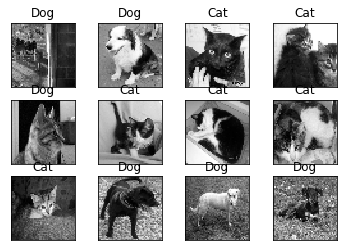

In [13]:
# Let's see how well our model is! 

fig = plt.figure()

for num, data in enumerate(test_data[:12]):
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3, 4, num+1)
    orig = img_data
    data = img_data.reshape(image_size, image_size, 1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_label="Dog"
    else:
        str_label="Cat"
        
    y.imshow(orig, cmap="gray")
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

plt.show()

In [14]:
# References for this project: https://pythonprogramming.net/convolutional-neural-network-kats-vs-dogs-machine-learning-tutorial/
